
---
# 01. Eksploracja Danych NYC Taxi 2016

Ten notebook zawiera wstępną analizę i eksplorację danych.

---

In [1]:
import sys
sys.path.append('/home/jovyan')

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import DataLoader
from config.spark_config import SPARK_CONFIG, MONGODB_CONFIG, DATA_PATHS
from src.preprocessing import DataPreprocessor


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1.1 Wczytanie Danych

In [2]:
# %% Inicjalizacja DataLoader i wczytanie danych
loader = DataLoader()
df_raw = loader.load_data()

# %% Informacje o zbiorze
loader.print_data_info(df_raw)

# %% Schema
print("\nSCHEMAT DANYCH:")
df_raw.printSchema()

# %% Podgląd danych
print("\nPRZYKŁADOWE DANE:")
df_raw.show(10, truncate=False)

Tworzenie sesji Spark...
Spark UI: http://localhost:4040
Master: local[*]
Spark Version: 3.5.0
Python Version: 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]

Wczytywanie danych z: /home/jovyan/data/yellow_tripdata_2015-*.csv
⚠️  UWAGA: Nie znaleziono plików pasujących do wzorca: /home/jovyan/data/yellow_tripdata_2015-*.csv
Upewnij się, że pliki CSV znajdują się w folderze 'data/'
✓ Wczytano 12,748,986 rekordów w 9.54 sekund

INFORMACJE O ZBIORZE DANYCH
Liczba rekordów: 12,748,986
Liczba kolumn: 19
Liczba partycji: 200

Kolumny:
  - VendorID
  - tpep_pickup_datetime
  - tpep_dropoff_datetime
  - passenger_count
  - trip_distance
  - pickup_longitude
  - pickup_latitude
  - RatecodeID
  - store_and_fwd_flag
  - dropoff_longitude
  - dropoff_latitude
  - payment_type
  - fare_amount
  - extra
  - mta_tax
  - tip_amount
  - tolls_amount
  - improvement_surcharge
  - total_amount

SCHEMAT DANYCH:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_

## 1.2 Analiza Brakujących Wartości

Analiza brakujących wartości...

BRAKUJĄCE WARTOŚCI:
               column  missing_count  missing_pct
             VendorID              0          0.0
     dropoff_latitude              0          0.0
improvement_surcharge              0          0.0
         tolls_amount              0          0.0
           tip_amount              0          0.0
              mta_tax              0          0.0
                extra              0          0.0
          fare_amount              0          0.0
         payment_type              0          0.0
    dropoff_longitude              0          0.0
 tpep_pickup_datetime              0          0.0
   store_and_fwd_flag              0          0.0
           RatecodeID              0          0.0
      pickup_latitude              0          0.0
     pickup_longitude              0          0.0
        trip_distance              0          0.0
      passenger_count              0          0.0
tpep_dropoff_datetime              0          0

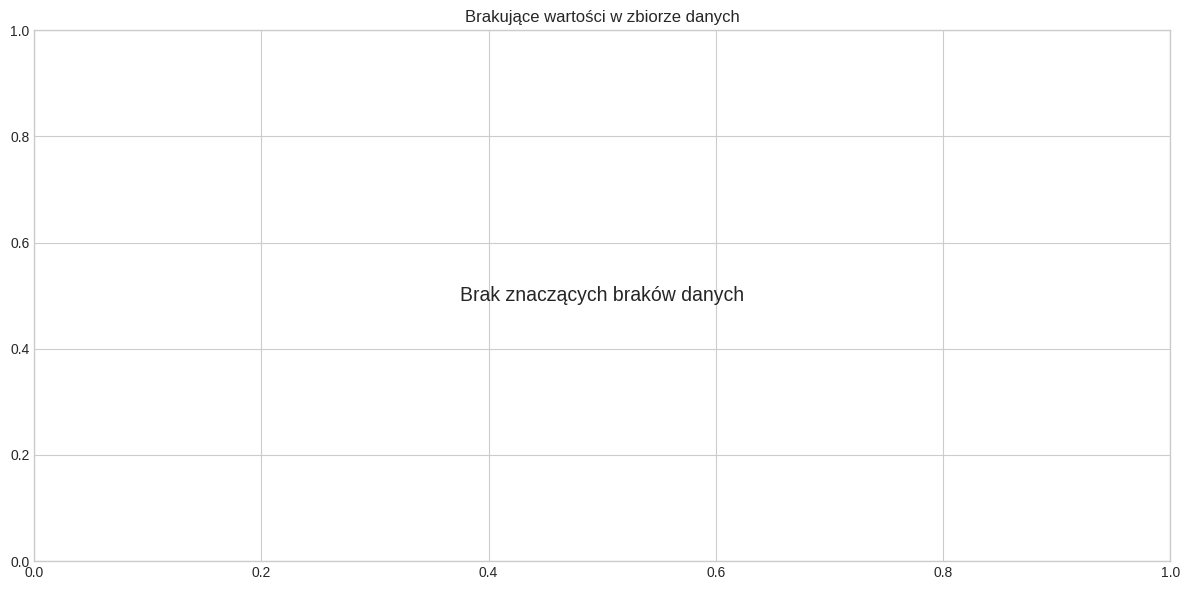

In [3]:
preprocessor = DataPreprocessor()
missing_df = preprocessor.analyze_missing_values(df_raw)

print("\nBRAKUJĄCE WARTOŚCI:")
print(missing_df.to_string(index=False))

# %% Wizualizacja braków
fig, ax = plt.subplots(figsize=(12, 6))
missing_filtered = missing_df[missing_df['missing_pct'] > 0]

if len(missing_filtered) > 0:
    bars = ax.barh(missing_filtered['column'], missing_filtered['missing_pct'], 
                   color='coral', edgecolor='darkred')
    ax.set_xlabel('Procent brakujących wartości (%)')
    ax.set_title('Brakujące wartości w zbiorze danych')
    ax.invert_yaxis()
else:
    ax.text(0.5, 0.5, 'Brak znaczących braków danych', 
            ha='center', va='center', fontsize=14)
    ax.set_title('Brakujące wartości w zbiorze danych')

plt.tight_layout()
plt.savefig('../reports/figures/00_missing_values.png', dpi=150)
plt.show()

## 1.3 Podstawowe Statystyki

In [4]:
print("\nSTATYSTYKI OPISOWE:")
numeric_cols = ["trip_distance", "fare_amount", "tip_amount", 
                "total_amount", "passenger_count"]
df_raw.select(numeric_cols).describe().show()

# %% Rozkład typów płatności
print("\nROZKŁAD TYPÓW PŁATNOŚCI:")
df_raw.groupBy("payment_type").count().orderBy("count", ascending=False).show()

# %% Rozkład liczby pasażerów
print("\nROZKŁAD LICZBY PASAŻERÓW:")
df_raw.groupBy("passenger_count").count().orderBy("passenger_count").show()



STATYSTYKI OPISOWE:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|        tip_amount|      total_amount|   passenger_count|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          12748986|          12748986|          12748986|          12748986|          12748986|
|   mean|13.459129611562814|11.905659425777053|1.8538136460421346|15.108294537316056|1.6814908260154964|
| stddev|  9844.09421846842| 10.30253713595225|1106.4323141838831|1106.5032467104768|1.3379235172874717|
|    min|               0.0|            -450.0|            -92.42|            -450.3|                 0|
|    max|      1.54200045E7|            4008.0|         3950588.8|         3950611.6|                 9|
+-------+------------------+------------------+------------------+------------------+------------------+


ROZKŁAD TYPÓW PŁATNOŚCI:
+------

## 1.4 Wstępne Wizualizacje (na próbce)

Rozmiar próbki: 99,949


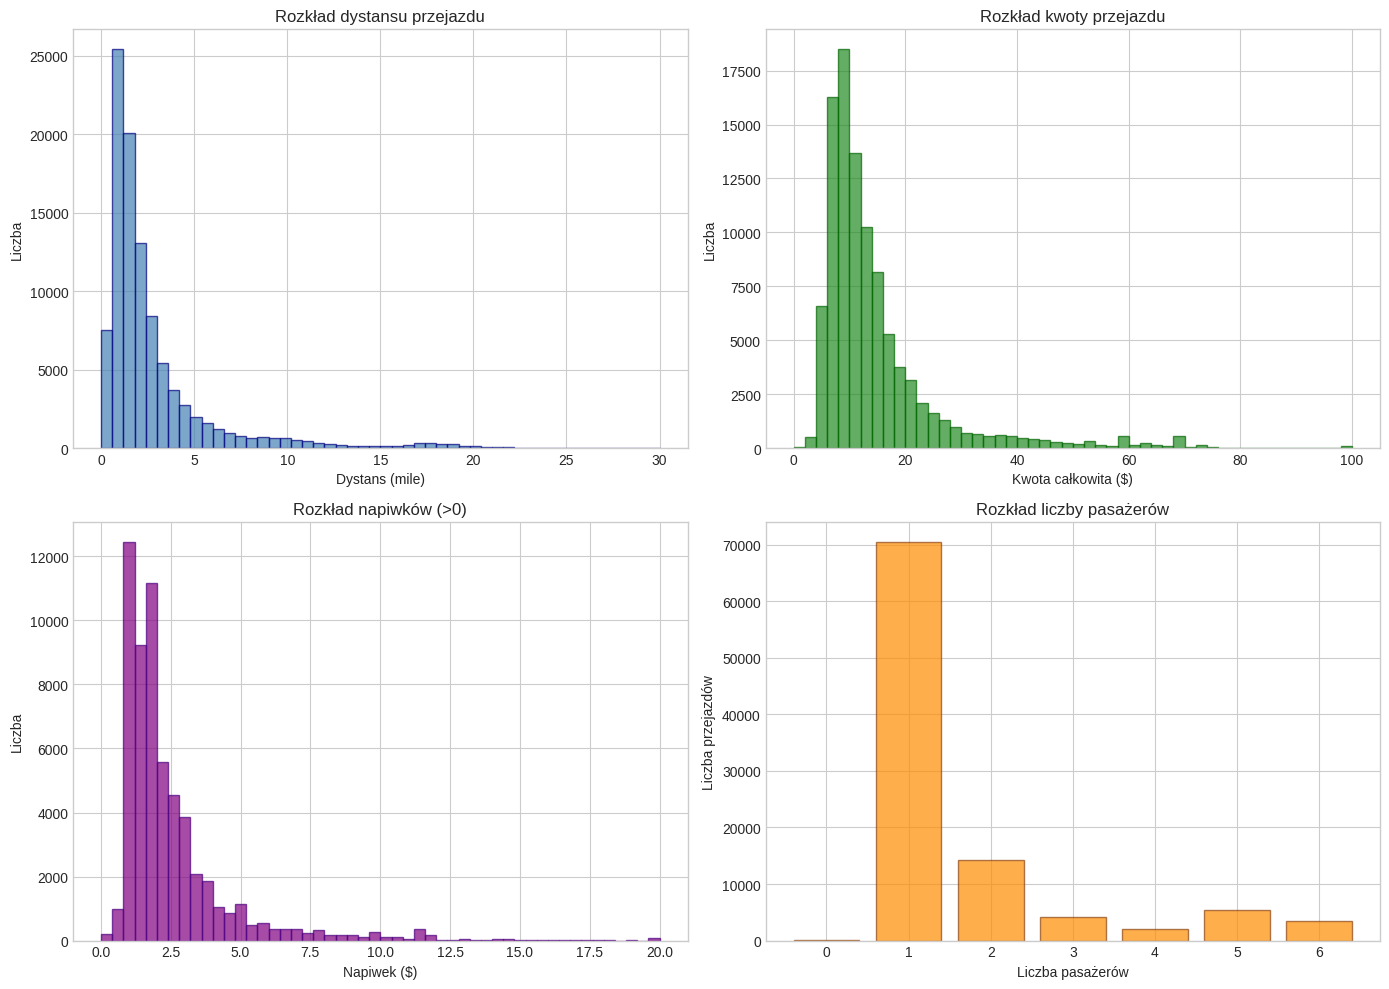

In [5]:
# %% Pobranie próbki do wizualizacji
sample_size = 100000
total_count = df_raw.count()
sample_fraction = sample_size / total_count

df_sample = df_raw.sample(fraction=sample_fraction, seed=42).toPandas()
print(f"Rozmiar próbki: {len(df_sample):,}")

# %% Rozkłady podstawowych zmiennych
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Dystans
axes[0, 0].hist(df_sample['trip_distance'].clip(0, 30), bins=50, 
                color='steelblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_xlabel('Dystans (mile)')
axes[0, 0].set_ylabel('Liczba')
axes[0, 0].set_title('Rozkład dystansu przejazdu')

# Kwota
axes[0, 1].hist(df_sample['total_amount'].clip(0, 100), bins=50,
                color='forestgreen', edgecolor='darkgreen', alpha=0.7)
axes[0, 1].set_xlabel('Kwota całkowita ($)')
axes[0, 1].set_ylabel('Liczba')
axes[0, 1].set_title('Rozkład kwoty przejazdu')

# Napiwek
tip_data = df_sample[df_sample['tip_amount'] > 0]['tip_amount'].clip(0, 20)
axes[1, 0].hist(tip_data, bins=50, color='purple', edgecolor='indigo', alpha=0.7)
axes[1, 0].set_xlabel('Napiwek ($)')
axes[1, 0].set_ylabel('Liczba')
axes[1, 0].set_title('Rozkład napiwków (>0)')

# Pasażerowie
passenger_counts = df_sample['passenger_count'].value_counts().sort_index()
axes[1, 1].bar(passenger_counts.index, passenger_counts.values,
               color='darkorange', edgecolor='saddlebrown', alpha=0.7)
axes[1, 1].set_xlabel('Liczba pasażerów')
axes[1, 1].set_ylabel('Liczba przejazdów')
axes[1, 1].set_title('Rozkład liczby pasażerów')

plt.tight_layout()
plt.savefig('../reports/figures/00_initial_distributions.png', dpi=150)
plt.show()

## 1.5 Analiza Wartości Odstających

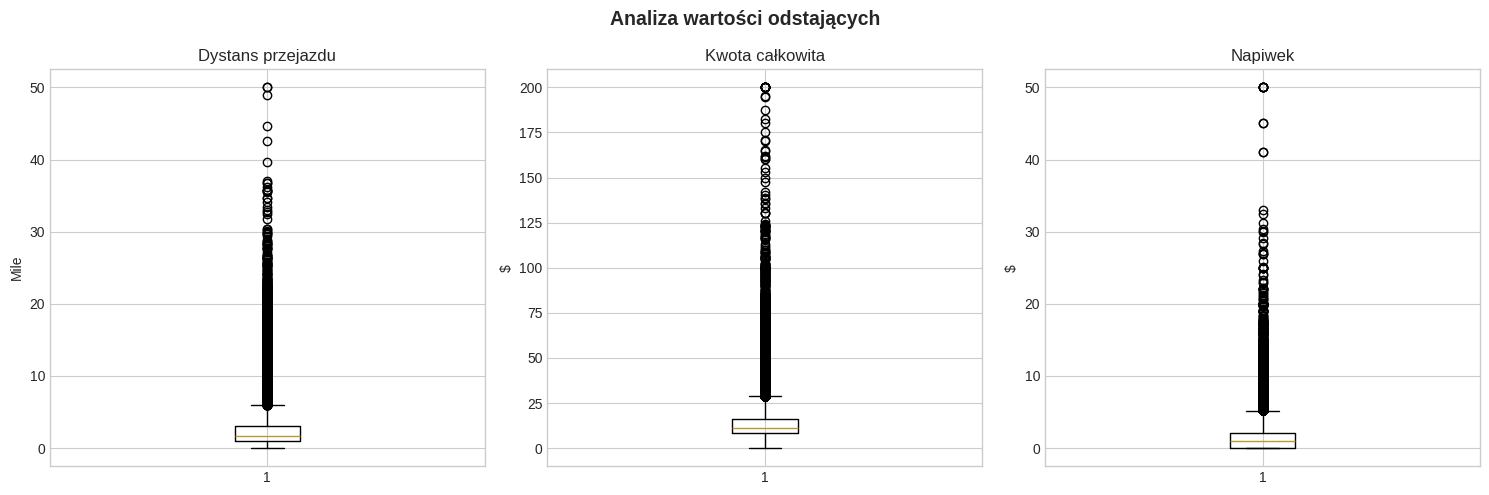

In [6]:

# %% Boxploty
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Dystans
axes[0].boxplot(df_sample['trip_distance'].clip(0, 50))
axes[0].set_ylabel('Mile')
axes[0].set_title('Dystans przejazdu')

# Kwota
axes[1].boxplot(df_sample['total_amount'].clip(0, 200))
axes[1].set_ylabel('$')
axes[1].set_title('Kwota całkowita')

# Napiwek
axes[2].boxplot(df_sample['tip_amount'].clip(0, 50))
axes[2].set_ylabel('$')
axes[2].set_title('Napiwek')

plt.suptitle('Analiza wartości odstających', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/00_outliers.png', dpi=150)
plt.show()

## 1.6 Podsumowanie Eksploracji

In [8]:
print("""
================================================================================
                    PODSUMOWANIE EKSPLORACJI DANYCH
================================================================================

1. ROZMIAR ZBIORU:
   - Liczba rekordów: {:,}
   - Liczba kolumn: 19
   
2. BRAKI DANYCH:
   - Niewielki procent braków w niektórych kolumnach
   - Wymagane czyszczenie danych geograficznych
   
3. WARTOŚCI ODSTAJĄCE:
   - Dystans: niektóre przejazdy >100 mil (do usunięcia)
   - Kwota: wartości <0 i >500$ (do usunięcia)
   - Napiwki: ujemne wartości (do usunięcia)
   
4. NASTĘPNE KROKI:
   - Czyszczenie danych (02_preprocessing.ipynb)
   - Feature engineering
   - Modelowanie ML (03_ml_modeling.ipynb)

================================================================================
""".format(total_count))



                    PODSUMOWANIE EKSPLORACJI DANYCH

1. ROZMIAR ZBIORU:
   - Liczba rekordów: 12,748,986
   - Liczba kolumn: 19
   
2. BRAKI DANYCH:
   - Niewielki procent braków w niektórych kolumnach
   - Wymagane czyszczenie danych geograficznych
   
3. WARTOŚCI ODSTAJĄCE:
   - Dystans: niektóre przejazdy >100 mil (do usunięcia)
   - Kwota: wartości <0 i >500$ (do usunięcia)
   - Napiwki: ujemne wartości (do usunięcia)
   
4. NASTĘPNE KROKI:
   - Czyszczenie danych (02_preprocessing.ipynb)
   - Feature engineering
   - Modelowanie ML (03_ml_modeling.ipynb)


